In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Pothole detection/My Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/105.Clairmont_Potholes-600x338.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/114.Pothole-1024x0-c-default.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/117.pothole.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/107.JA_BRK_190318_Pothole_01.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/11.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/119.5145985_021919-kfsn-4p-potholes-vid.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/120.636554993224215719-INI1Brd-02-24-2018-Star-1-A001-2018-02-23-IMG-INI1Brd-02-18-2018-S-1-1-KML931O2-L1186531823-IMG-INI1Brd-02-18-2018-S-1-1-KML931O2.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/10.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/102.5bf2a7765728d.jpg
/content/drive/MyDrive/Pothole detection/My Dataset/

In [3]:
pip install tensorflow

In [4]:
import random
import copy
import math
from typing import Tuple, Dict, Any, List
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torchvision.transforms as T
import torchvision.datasets as datasets
import timm  # EfficientNet backbones via timm
import pywt
from sklearn.metrics import accuracy_score

In [5]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 #model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
import tensorflow as tf
import random as rn
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam

In [6]:
os.listdir('../content/drive/MyDrive/Pothole detection/My Dataset')

['train', 'test']

In [7]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass

def assign_label(img,label):
    return label

In [8]:
X=[]
Z=[]
IMG_SIZE=256
Plain='../content/drive/MyDrive/Pothole detection/My Dataset/train/Plain'
Pothole='../content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 357/357 [00:16<00:00, 22.25it/s]


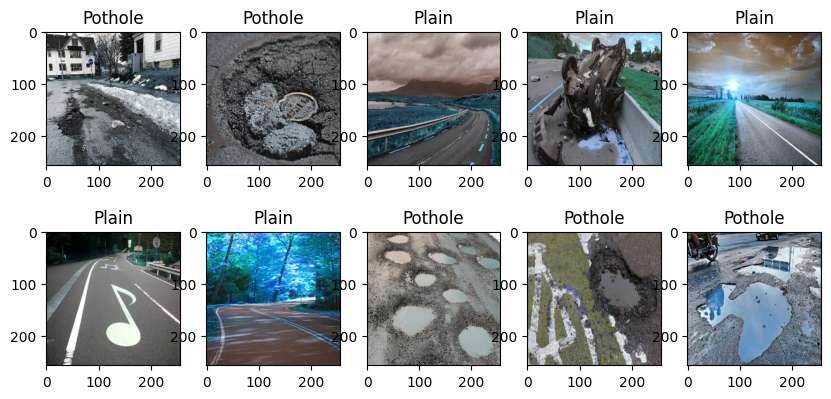

In [9]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

**data Preprocessing**

In [10]:
pip install opencv-python numpy


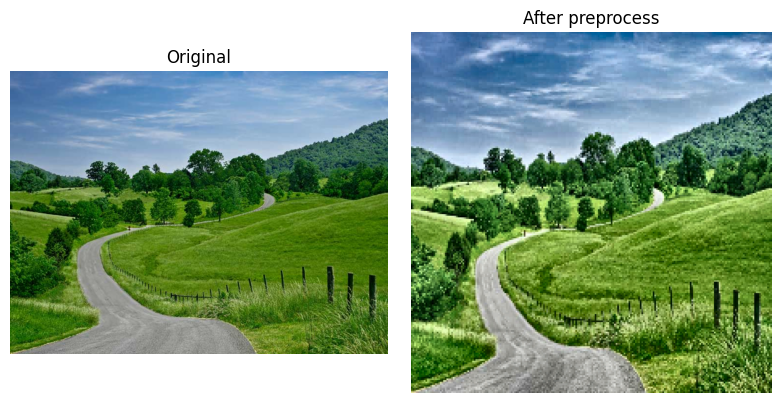

In [11]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random

def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)                        # B G R
    img_resized = cv2.resize(img, target_size)

    # --- Convert to LAB and apply CLAHE on L-channel ---
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # --- Normalize (0–1) ---
    img_normalized = img_enhanced.astype(np.float32) / 255.0

    return img_normalized

# ---- pick a sample file -----------------------------------------------------
image_dir = "/content/drive/MyDrive/Pothole detection/My Dataset/train/Plain"
all_imgs  = [f for f in os.listdir(image_dir)
             if f.lower().endswith((".png", ".jpg", ".jpeg"))]
sample    = random.choice(all_imgs)
sample_fp = os.path.join(image_dir, sample)

# ---- run your preprocessing -------------------------------------------------
original_bgr = cv2.imread(sample_fp)
processed    = preprocess_image(sample_fp)

# ---- convert BGR->RGB for plotting ------------------------------------------
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
processed_rgb = (processed * 255).astype(np.uint8)      # back to 0-255
processed_rgb = cv2.cvtColor(processed_rgb, cv2.COLOR_BGR2RGB)

# ---- plot side-by-side ------------------------------------------------------
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(original_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(processed_rgb)
plt.title("After preprocess")
plt.axis("off")

plt.tight_layout()
plt.show()


**Data Augmentation**

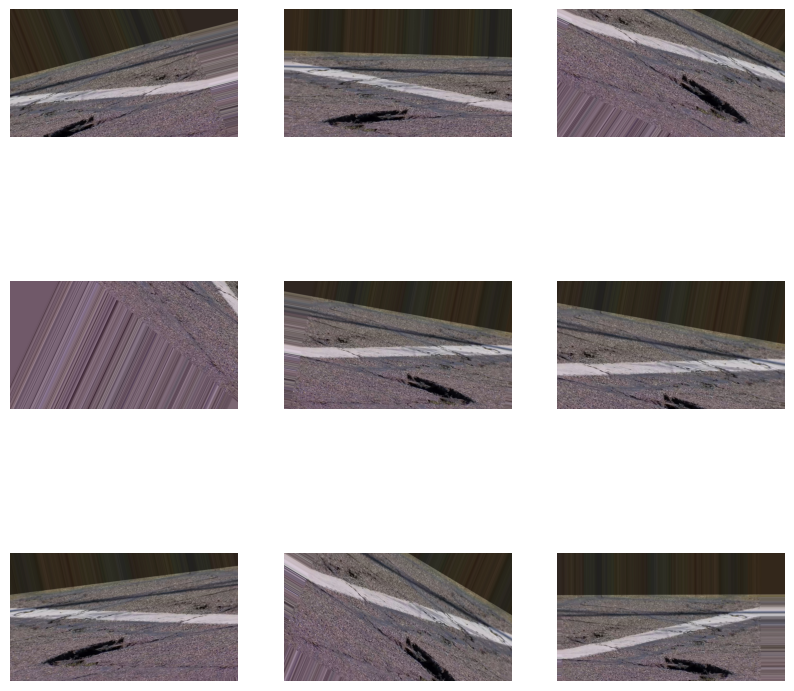

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load an example image
image_path = "/content/drive/MyDrive/Pothole detection/My Dataset/train/Pothole/119.5145985_021919-kfsn-4p-potholes-vid.jpg"  # Replace with your image path
image = tf.keras.preprocessing.image.load_img(image_path)
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = image_array.reshape((1,) + image_array.shape)  # Reshape for augmentation

# Generate augmented images
augmented_images = datagen.flow(image_array, batch_size=1)

# Display some augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    batch = next(augmented_images)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')

plt.show()


**WTSA**

In [13]:
import torch.nn as nn
import pywt

class WTSA(nn.Module):
    def __init__(self, in_channels):
        super(WTSA, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Apply wavelet transform
        coeffs = pywt.wavedec2(x.cpu().numpy(), 'haar', level=1)
        cA, (cH, cV, cD) = coeffs

        # Convert back to tensor
        cA, cH, cV, cD = map(lambda arr: torch.tensor(arr).to(x.device), [cA, cH, cV, cD])

        # Apply attention mechanism
        attention_map = self.softmax(self.conv1x1(cA))
        enhanced_features = attention_map * cA

        return enhanced_features

class TripletAttention(nn.Module):
    """
    A compact triplet-attention style module that computes attention across
    different axis permutations (channel, height, width) and merges them.
    Adapted for clarity and efficiency.
    """
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        mid = max(8, in_channels // reduction)
        self.conv1 = nn.Conv2d(in_channels, mid, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(mid, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-att
        c_att = x.mean(dim=(2,3), keepdim=True)  # (N,C,1,1)
        c = self.conv1(c_att)
        c = F.relu(c, inplace=True)
        c = self.conv2(c)
        c = self.sigmoid(c)  # (N,C,1,1)

        # Spatial att (height)
        h_att = x.mean(dim=1, keepdim=True)  # (N,1,H,W)
        h = self.conv1(h_att)
        h = F.relu(h, inplace=True)
        h = self.conv2(h)
        h = self.sigmoid(h)

        # Spatial att (width) — use permute
        w_att = x.mean(dim=1, keepdim=True).permute(0,1,3,2)
        w = self.conv1(w_att)
        w = F.relu(w, inplace=True)
        w = self.conv2(w)
        w = self.sigmoid(w).permute(0,1,3,2)

        out = x * c * h * w
        return out

**EfficientNet**

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB7 # You can choose B0 to B7

# Define the number of classes for your problem (e.g., 2 for Pothole and Plain)
num_classes = 2

# Load a pre-trained EfficientNet model (e.g., EfficientNetB0)
# 'weights' can be 'imagenet' for ImageNet pre-trained weights, or None for random initialization.
# 'include_top=False' removes the classification head, allowing you to add your own.
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being updated during initial training
base_model.trainable = False

# Create a new model on top of the pre-trained base
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) # Important: set training=False when using base_model as a feature extractor
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x) # num_classes is your specific number of classes

model = keras.Model(inputs, outputs)

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(...)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [15]:
from tensorflow.keras.applications import EfficientNetB7

base_model = EfficientNetB7 (
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3),
    pooling='max'  # Global max pooling
)

base_model.summary()


Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

**WTSA-EfficientNet model**

In [16]:
class WTSAEfficientNet(nn.Module):
    """
    EfficientNet backbone (from timm) with:
     - Replace SE blocks with TripletAttention (approx) at select points
     - Insert StochNorm after chosen blocks
     - Wavelet decomposition applied to early conv feature maps and fused back
    Note: This is an adaptable skeleton — paper used EfficientNet-B7; we use timm model var.
    """
    def __init__(self, backbone_name='tf_efficientnet_b0', num_classes=2, use_wavelet=True):
        super().__init__()
        self.backbone_name = backbone_name
        self.num_classes = num_classes
        self.use_wavelet = use_wavelet

        self.backbone = timm.create_model(backbone_name, pretrained=True, features_only=True)
        feat_channels = self.backbone.feature_info.channels()  # list of channels per stage
        # We'll build a small head that integrates triplet attention and StochNorm
        self.attn_blocks = nn.ModuleList()
        self.stochnorm_blocks = nn.ModuleList()
        for ch in feat_channels:
            self.attn_blocks.append(TripletAttention(ch))
            self.stochnorm_blocks.append(StochNorm(ch))

        # final classifier head
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(feat_channels[-1], num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)  # list of feature maps from early->deep
        # optionally wavelet-process the first stage
        if self.use_wavelet and len(features) > 0:
            f0 = features[0]
            # wavelet decomposition and upsample back to original size and fuse
            try:
                w = wavelet_decompose_cat(f0)  # (N, C*4, H/2, W/2)
                # bring to same spatial size by interpolation
                w_up = F.interpolate(w, size=f0.shape[2:], mode='bilinear', align_corners=False)
                features[0] = features[0] + w_up.to(features[0].device)
            except Exception as e:
                # pywt may fail on small dims; safe fallback
                pass

        # pass through attentions & stochNorm for each feature stage
        out = features[-1]
        for i, f in enumerate(features):
            f = self.attn_blocks[i](f)
            f = self.stochnorm_blocks[i](f)
            if i == len(features) - 1:
                out = f

        pooled = self.pool(out).squeeze(-1).squeeze(-1)
        logits = self.fc(pooled)
        return logits

**Soft clipping swish**

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

# Define Soft Clipping Swish
def soft_clipping_swish(x):
    return x * tf.nn.sigmoid(x)  # You can adjust this if you have a specific "soft clipping"

# Register it as a custom activation
get_custom_objects().update({'soft_clipping_swish': Activation(soft_clipping_swish)})


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
# create dataset train
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Pothole detection/My Dataset/train',
                                                 target_size = (300, 300),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
# Create test data set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Pothole detection/My Dataset/test',
                                            target_size = (300, 300),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 723 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [20]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Assuming base_model was created in a previous cell
# from tensorflow.keras.applications import EfficientNetB7
# base_model = EfficientNetB7(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(256, 256, 3),
#     pooling='max'  # Global max pooling
# )

# Define base_model here to ensure it exists before use
base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3), # Use the target size from flow_from_directory
    pooling='max'  # Global max pooling
)


# Add a dense layer with 2 units (for 2 classes) and softmax activation
x = base_model.output
predictions = Dense(2, activation='softmax')(x) # 2 units for 'Plain' and 'Pothole'

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

opt=Adam(learning_rate=0.0001)
# Compile the new model
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

# Use the compiled Keras model (model) for training
# Also, use the recommended 'fit' method instead of 'fit_generator'
history = model.fit(training_set,
                              validation_data=test_set,
                              epochs=10)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 630s 13s/step - accuracy: 0.7436 - loss: 0.7070 - val_accuracy: 0.5000 - val_loss: 0.9146
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9795 - loss: 0.0782 - val_accuracy: 0.5000 - val_loss: 2.7802
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9872 - loss: 0.0460 - val_accuracy: 0.5000 - val_loss: 1.1243
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9783 - loss: 0.0514 - val_accuracy: 0.5000 - val_loss: 2.8967
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9936 - loss: 0.0239 - val_accuracy: 0.5000 - val_loss: 2.2612
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.5000 - val_loss: 2.7207
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9949 - loss: 0.0112 - val_accuracy: 0.5000 - val_loss: 1.1826
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9860 - loss: 0.0241 - val_accuracy: 0.5000 - val_los

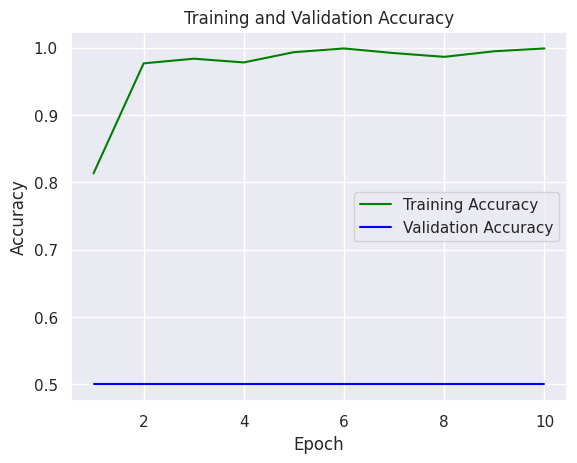

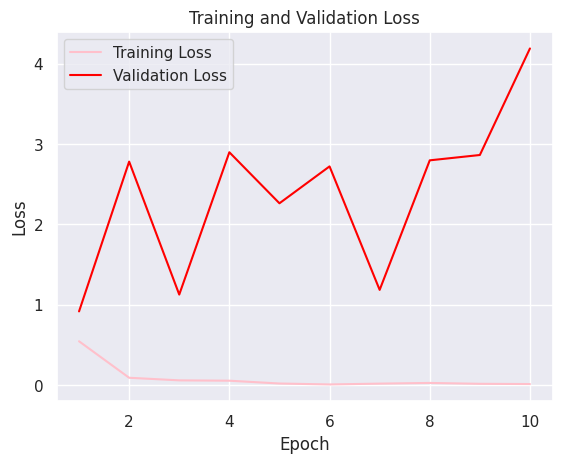

In [21]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Saving 3._106177564_pothole.jpg to 3._106177564_pothole.jpg


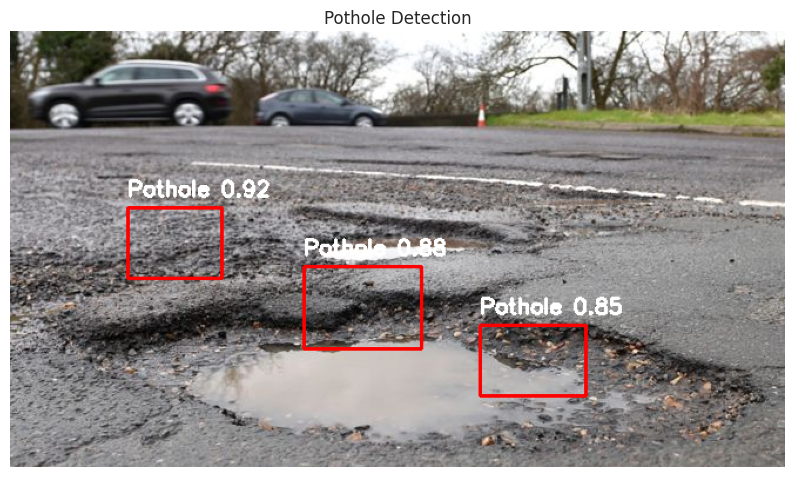

In [40]:

!pip install matplotlib opencv-python-headless

import cv2
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np

uploaded = files.upload()


for filename in uploaded.keys():
    image_path = filename


def detect_and_annotate(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Dummy detections: replace this with your model predictions
    detections = [
        (100, 150, 80, 60, 0.92),
        (250, 200, 100, 70, 0.88),
        (400, 250, 90, 60, 0.85),
    ]

    for (x, y, w, h, conf) in detections:
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
        label = f'Pothole {conf:.2f}'
        cv2.putText(image_rgb, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Pothole Detection")
    plt.show()

# Step 6: Run detection
detect_and_annotate(image_path)


**Stochastic Normalization (StochNorm)**

In [23]:
import torch.nn as nn

class StochNorm(nn.Module):
    """
    Stochastic Normalization: randomly select between Batch statistics or running statistics.
    Implementation based on the algorithm description in the paper.
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1, p=0.5):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.p = p  # probability to choose batch statistics
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        if self.training:
            if torch.rand(1).item() < self.p:
                # use batch stats
                mean = x.mean(dim=[0,2,3])
                var = x.var(dim=[0,2,3], unbiased=False)
                # update running
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.detach()
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var.detach()
                mean_b = mean.view(1, -1, 1, 1)
                var_b = var.view(1, -1, 1, 1)
                out = (x - mean_b) / (torch.sqrt(var_b + self.eps))
            else:
                # use running (moving) stats
                mean = self.running_mean.view(1, -1, 1, 1)
                var = self.running_var.view(1, -1, 1, 1)
                out = (x - mean) / (torch.sqrt(var + self.eps))
        else:
            # inference: always use running stats
            mean = self.running_mean.view(1, -1, 1, 1)
            var = self.running_var.view(1, -1, 1, 1)
            out = (x - mean) / (torch.sqrt(var + self.eps))
        out = out * self.gamma.view(1, -1, 1, 1) + self.beta.view(1, -1, 1, 1)
        return out

**FL based AGMRFO Optimization**

In [24]:
def federated_round(global_model, client_loaders, epochs_local, lr, device, backbone_name='tf_efficientnet_b0'):
    """
    global_model: model state_dict or nn.Module
    client_loaders: list of (train_loader, val_loader) tuples per client
    returns aggregated global state_dict
    """
    # instantiate model per client
    client_states = []
    client_sizes = []
    for (train_loader, _val_loader) in client_loaders:
        model = WTSAEfficientNet(backbone_name=backbone_name).to(device)
        model.load_state_dict(global_model.state_dict())
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        # local training
        for e in range(epochs_local):
            train_one_epoch(model, train_loader, optimizer, criterion, device)
        client_states.append(copy.deepcopy(model.state_dict()))
        # count data size
        total = len(train_loader.dataset)
        client_sizes.append(total)
    # weighted averaging
    new_state = {}
    total_samples = sum(client_sizes)
    for k in client_states[0].keys():
        new_state[k] = sum([client_states[i][k].float() * (client_sizes[i] / total_samples) for i in range(len(client_states))])
    # load into global
    global_model.load_state_dict(new_state)
    return global_model


**AGMRFO-for hyperparameter tunning**

In [52]:
import numpy as np
import random
import math
from typing import Dict, List, Any, Tuple

class AGMRFO_Tuner:
    """
    AGMRFO tuner adapted to mixed search spaces (continuous + discrete).
    - search_space: dict. For continuous params give tuple (low, high), for categorical give list of options.
      Example:
        search_space = {
            'lr': (1e-5, 1e-2),
            'batch_size': [8, 16, 32],
            'epochs_local': [1,2,3],
            'dropout': (0.0, 0.5),
            'kernel': [3,5],
            'optimizer': ['sgd','adam'],
            'activation': ['relu','swish']
        }
    - pop_size: population size
    - k_max: maximum iterations
    - nfe_max: optional max number of function evaluations (set None to ignore)
    - device/backbone: passed to eval_solution if needed (your eval_solution already uses these attrs)
    """
    def __init__(self,
                 search_space: Dict[str, Any],
                 pop_size: int = 10,
                 k_max: int = 20,
                 nfe_max: int = 1000,
                 device='cpu',
                 backbone=None,
                 k1=0.8, k2=0.2, k3=0.8, k4=0.2,
                 somersault_factor=2.0,
                 seed: int = 42):
        random.seed(seed)
        np.random.seed(seed)

        self.search_space = search_space
        self.pop_size = pop_size
        self.k_max = k_max
        self.nfe_max = nfe_max
        self.device = device
        self.backbone = backbone

        # adaptive constants (k1,k2 for Ap_c ; k3,k4 for Ap_m)
        self.k1 = float(k1)
        self.k2 = float(k2)
        self.k3 = float(k3)
        self.k4 = float(k4)

        self.somersault_factor = somersault_factor

        # internal structures
        # Determine encoding (continuous dims and categorical mapping)
        self._keys = list(search_space.keys())
        self._is_cont = []
        self._bounds = []
        self._cat_values = []

        for k in self._keys:
            v = search_space[k]
            if isinstance(v, tuple) or isinstance(v, list) and len(v) == 2 and isinstance(v[0], (int,float)) and isinstance(v[1], (int,float)) and not isinstance(v, np.ndarray):
                # treat as continuous bound
                self._is_cont.append(True)
                self._bounds.append((float(v[0]), float(v[1])))
                self._cat_values.append(None)
            elif isinstance(v, list) or isinstance(v, tuple):
                # categorical
                self._is_cont.append(False)
                self._bounds.append((0, len(v)-1))
                self._cat_values.append(list(v))
            else:
                raise ValueError(f"Unsupported search_space type for key {k}: {type(v)}")

        self.dim = len(self._keys)
        # initialize population (as decoded dicts)
        self.population = [self._random_solution_dict() for _ in range(pop_size)]
        self.fitness = np.full(pop_size, -np.inf, dtype=float)  # larger is better (accuracy)
        self.nfe = 0

    # -----------------------------
    # Encoding / decoding helpers
    # -----------------------------
    def _random_solution_dict(self) -> Dict[str, Any]:
        sol = {}
        for i, k in enumerate(self._keys):
            if self._is_cont[i]:
                lo, hi = self._bounds[i]
                val = random.uniform(lo, hi)
                sol[k] = float(val)
            else:
                vals = self._cat_values[i]
                sol[k] = random.choice(vals)
        return sol

    def _dict_to_vector(self, sol: Dict[str, Any]) -> np.ndarray:
        vec = np.zeros(self.dim, dtype=float)
        for i,k in enumerate(self._keys):
            if self._is_cont[i]:
                lo, hi = self._bounds[i]
                # scale to [lo, hi] value
                vec[i] = float(sol[k])
            else:
                # categorical -> index
                vec[i] = float(self._cat_values[i].index(sol[k]))
        return vec

    def _vector_to_dict(self, vec: np.ndarray) -> Dict[str, Any]:
        sol = {}
        for i,k in enumerate(self._keys):
            if self._is_cont[i]:
                lo, hi = self._bounds[i]
                # clamp
                v = float(vec[i])
                v = max(lo, min(hi, v))
                sol[k] = v
            else:
                idx = int(round(vec[i]))
                idx = max(0, min(len(self._cat_values[i]) - 1, idx))
                sol[k] = self._cat_values[i][idx]
        return sol

    # -----------------------------
    # Safe roulette selection
    # -----------------------------
    def _roulette_select(self, fitness: np.ndarray) -> int:
        # convert fitness to non-negative weights
        w = np.copy(fitness).astype(float)
        # if fitness could be negative, shift
        min_f = w.min()
        if not math.isfinite(min_f):
            w = np.zeros_like(w) + 1.0
        else:
            if min_f < 0:
                w = w - min_f + 1e-6
        # avoid all zeros
        if w.sum() == 0 or np.isnan(w).any():
            probs = np.ones_like(w) / len(w)
        else:
            probs = w / w.sum()
        return int(np.random.choice(len(w), p=probs))

    # -----------------------------
    # Adaptive probs for crossover & mutation (per formulas)
    # -----------------------------
    def _compute_adaptive_probs(self, fitness: np.ndarray) -> List[Tuple[float, float]]:
        if fitness.size == 0:
            return [(self.k1, self.k3) for _ in range(self.pop_size)]
        f_max = float(np.nanmax(fitness))
        f_avg = float(np.nanmean(fitness))
        probs = []
        denom = (f_max - f_avg) if (f_max - f_avg) != 0 else 1e-9
        for f in fitness:
            if f >= f_avg:
                Ap_c = self.k1 * ((f_max - f) / denom) if denom != 0 else self.k2
                Ap_c = max(0.0, min(1.0, Ap_c))
                Ap_m = self.k3 * ((f_max - f) / denom) if denom != 0 else self.k4
                Ap_m = max(0.0, min(1.0, Ap_m))
            else:
                Ap_c = self.k2  # weaker individuals get higher crossover (as per narrative)
                Ap_m = min(1.0, self.k1 * ((f_avg - f) / (f_avg + 1e-9)))
                Ap_c = max(0.0, min(1.0, Ap_c))
                Ap_m = max(0.0, min(1.0, Ap_m))
            probs.append((float(Ap_c), float(Ap_m)))
        return probs

    # -----------------------------
    # Foraging operators (moves)
    # -----------------------------
    def _cyclone_foraging(self, x, x_best, iter_idx, k_max):
        # cyclone move: move toward best with rotating perturbation
        r = random.random()
        t = iter_idx / (k_max + 1e-9)
        # safe vector math
        return x + (x_best - x) * (r * t + 0.1 * (random.random() - 0.5))

    def _chain_foraging(self, x, neighbors):
        # chain: follow random neighbor plus small random step
        j = random.randrange(len(neighbors))
        return x + 0.5 * (neighbors[j] - x) + 0.1 * np.random.randn(self.dim)

    def _somersault_foraging(self, x, x_best):
        S = self.somersault_factor
        r1 = np.random.rand(self.dim)
        r2 = np.random.rand(self.dim)
        return x + S * (r1 * x_best - r2 * x)

    def _adaptive_crossover(self, parent1_vec, parent2_vec, pc):
        child = np.copy(parent1_vec)
        for i in range(self.dim):
            if random.random() > pc:
                child[i] = parent2_vec[i]
        return child

    def _adaptive_mutation(self, vec, pm):
        new = np.copy(vec)
        for i in range(self.dim):
            if random.random() < pm:
                if self._is_cont[i]:
                    lo, hi = self._bounds[i]
                    # gaussian perturbation scaled to range
                    range_span = max(1e-9, hi - lo)
                    new[i] = new[i] + np.random.normal(scale=0.1*range_span)
                else:
                    # move index by +/-1 randomly
                    new[i] = new[i] + random.choice([-1, 1])
        return new

    # -----------------------------
    # The main run loop
    # -----------------------------
    def run(self, dataloaders_per_client) -> Tuple[Dict[str,Any], float]:
        # initial evaluation
        for i, sol in enumerate(self.population):
            # use self.eval_solution defined in class or subclass - returns validation accuracy
            try:
                f = self.eval_solution(sol, dataloaders_per_client, quick_epochs=1)
            except Exception as e:
                print("Eval exception during init:", e)
                f = 0.0
            self.fitness[i] = float(f)
            self.nfe += 1
            if self.nfe_max and self.nfe >= self.nfe_max:
                break

        # keep a numeric population representation
        pop_vecs = np.array([self._dict_to_vector(sol) for sol in self.population], dtype=float)

        # main iterations
        iter_idx = 0
        while iter_idx < self.k_max and (self.nfe_max is None or self.nfe < self.nfe_max):
            iter_idx += 1
            probs_adaptive = self._compute_adaptive_probs(self.fitness)
            new_offspring = []
            new_off_fitness = []

            for i in range(self.pop_size):
                # Selection via roulette
                p_idx = self._roulette_select(self.fitness)
                q_idx = random.randrange(self.pop_size)

                parent1 = pop_vecs[p_idx].copy()
                parent2 = pop_vecs[q_idx].copy()
                pc, pm = probs_adaptive[p_idx]

                # Foraging decision: cyclone vs chain
                r1 = random.random()
                threshold = iter_idx / (self.k_max + 1e-9)
                if r1 < threshold:
                    child_vec = self._cyclone_foraging(parent1, pop_vecs[np.argmax(self.fitness)], iter_idx, self.k_max)
                else:
                    # chain foraging uses other individuals as neighbors
                    child_vec = self._chain_foraging(parent1, pop_vecs)

                # Adaptive crossover & mutation
                child_vec = self._adaptive_crossover(child_vec, parent2, pc)
                child_vec = self._adaptive_mutation(child_vec, pm)

                # occasionally somersault (exploitation)
                if random.random() < 0.2:
                    child_vec = self._somersault_foraging(child_vec, pop_vecs[np.argmax(self.fitness)])

                # decode and evaluate
                child_dict = self._vector_to_dict(child_vec)
                try:
                    f_child = self.eval_solution(child_dict, dataloaders_per_client, quick_epochs=1)
                except Exception as e:
                    print("Eval exception for offspring:", e)
                    f_child = 0.0

                # record
                new_offspring.append(child_dict)
                new_off_fitness.append(float(f_child))
                self.nfe += 1
                if self.nfe_max and self.nfe >= self.nfe_max:
                    break

            # combine parent + offspring populations
            combined = list(self.population) + new_offspring
            combined_f = np.concatenate([self.fitness, np.array(new_off_fitness, dtype=float)])

            # select top pop_size by fitness
            idxs = np.argsort(-combined_f)[:self.pop_size]
            self.population = [combined[i] for i in idxs]
            self.fitness = combined_f[idxs]

            # update numeric vectors
            pop_vecs = np.array([self._dict_to_vector(sol) for sol in self.population], dtype=float)

            print(f"[AGMRFO] Iter {iter_idx}/{self.k_max}  Best fitness: {self.fitness.max():.4f}  NFE: {self.nfe}")
            # optional verbose top param
            best_idx = int(np.argmax(self.fitness))
            best_sol = self.population[best_idx]
            # continue until iterations or NFE exhausted

            if self.nfe_max and self.nfe >= self.nfe_max:
                print("[AGMRFO] Reached NFE limit.")
                break

        # final best
        best_idx = int(np.argmax(self.fitness))
        return self.population[best_idx], float(self.fitness[best_idx])


Init sol 0: {'lr': 0.001, 'batch_size': 32, 'dropout': 0.5, 'optimizer': 'sgd'} -> fitness 0.3670
Init sol 1: {'lr': 0.005, 'batch_size': 16, 'dropout': 0.3, 'optimizer': 'adam'} -> fitness 0.7544
Init sol 2: {'lr': 0.01, 'batch_size': 64, 'dropout': 0.5, 'optimizer': 'adam'} -> fitness 0.4907
Init sol 3: {'lr': 0.01, 'batch_size': 64, 'dropout': 0.3, 'optimizer': 'adam'} -> fitness 0.4089
=== Tuner Iter 1 ===
Top fitness: 0.7544410365682447 params: {'lr': 0.005, 'batch_size': 16, 'dropout': 0.3, 'optimizer': 'adam'}
=== Tuner Iter 2 ===
Top fitness: 0.7544410365682447 params: {'lr': 0.005, 'batch_size': 16, 'dropout': 0.3, 'optimizer': 'adam'}
=== Tuner Iter 3 ===
Top fitness: 0.7544410365682447 params: {'lr': 0.005, 'batch_size': 16, 'dropout': 0.3, 'optimizer': 'adam'}
=== Tuner Iter 4 ===
Top fitness: 0.8138728643486232 params: {'lr': 0.01, 'batch_size': 64, 'dropout': 0.2, 'optimizer': 'sgd'}
=== Tuner Iter 5 ===
Top fitness: 0.8138728643486232 params: {'lr': 0.01, 'batch_size': 6

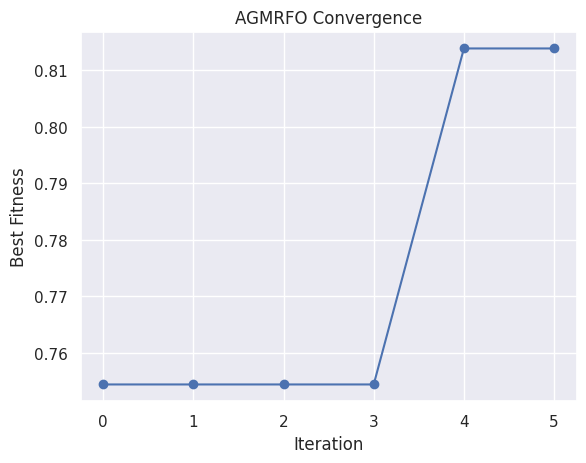

In [57]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

class WTSAEfficientNet(nn.Module):
    def __init__(self, backbone_name="tf_efficientnet_b7"):
        super().__init__()
        self.dummy = nn.Linear(10, 2)  # replace with your real backbone

    def forward(self, x):
        return self.dummy(x)

def federated_round(global_model, dataloaders_per_client, epochs_local=1, lr=0.001, device="cpu", backbone_name="tf_efficientnet_b0"):
    # placeholder: just return model (replace with your federated training code)
    return global_model

def eval_model(model, val_loader, criterion, device):
    # placeholder: returns (loss, acc)
    return 0.5, random.random()


# =========================
# AGMRFO Tuner
# =========================
class AGMRFO_Tuner:
    """
    AGMRFO-based hyperparameter tuner.
    Each solution is a hyperparameter set.
    Fitness = validation accuracy after short federated training.
    """

    def __init__(self, search_space, pop_size=8, iters=10, device='cpu', backbone='tf_efficientnet_b0'):
        self.search_space = search_space
        self.pop_size = pop_size
        self.iters = iters
        self.device = device
        self.backbone = backbone
        self.population = [self.random_solution() for _ in range(pop_size)]
        self.fitness = np.zeros(pop_size)
        self.best_fitness_history = []   # track best fitness per iteration

        # constants for adaptive probabilities
        self.c1 = 0.8
        self.c2 = 0.2

    def random_solution(self):
        sol = {}
        for k, v in self.search_space.items():
            sol[k] = random.choice(v)
        return sol

    def eval_solution(self, sol, dataloaders_per_client, quick_epochs=1):
        global_model = WTSAEfficientNet(backbone_name=self.backbone).to(self.device)
        try:
            global_model = federated_round(global_model, dataloaders_per_client,
                                           epochs_local=quick_epochs,
                                           lr=sol['lr'],
                                           device=self.device,
                                           backbone_name=self.backbone)
            val_accs = []
            criterion = nn.CrossEntropyLoss()
            for (_train, val_loader) in dataloaders_per_client:
                _, acc = eval_model(global_model, val_loader, criterion, self.device)
                val_accs.append(acc)
            return np.mean(val_accs)
        except Exception as e:
            print("Eval exception:", e)
            return 0.0

    def adapt_probs(self, fitness):
        max_f = fitness.max() if fitness.size else 1.0
        avg_f = fitness.mean() if fitness.size else 1.0
        probs = []
        for f in fitness:
            if f >= avg_f:
                pm = max(0.01, self.c2 * (avg_f / (f + 1e-9)))
                pc = max(0.1, self.c1 * (f / (max_f + 1e-9)))
            else:
                pm = min(0.9, self.c1 * (avg_f / (f + 1e-9)))
                pc = min(0.9, self.c2 * (f / (avg_f + 1e-9)))
            probs.append((pc, pm))
        return probs

    def crossover(self, parent1, parent2, pc):
        child = {}
        for k in parent1.keys():
            if random.random() < pc:
                child[k] = parent1[k]
            else:
                child[k] = parent2[k]
        return child

    def mutate(self, sol, pm):
        new = sol.copy()
        for k, vals in self.search_space.items():
            if random.random() < pm:
                new[k] = random.choice(vals)
        return new

    def run(self, dataloaders_per_client):
        # initial evaluation
        for i, sol in enumerate(self.population):
            self.fitness[i] = self.eval_solution(sol, dataloaders_per_client)
            print(f"Init sol {i}: {sol} -> fitness {self.fitness[i]:.4f}")
        self.best_fitness_history.append(self.fitness.max())

        for iter_idx in range(self.iters):
            print(f"=== Tuner Iter {iter_idx+1} ===")
            probs = self.adapt_probs(self.fitness)

            # offspring generation
            offspring = []
            for i in range(self.pop_size):
                p = np.maximum(0, self.fitness)
                if p.sum() == 0:
                    p = np.ones_like(p) / len(p)
                else:
                    p = p / p.sum()

                idx1 = np.random.choice(self.pop_size, p=p)
                idx2 = np.random.randint(self.pop_size)

                pc, pm = probs[idx1]
                child = self.crossover(self.population[idx1], self.population[idx2], pc)
                child = self.mutate(child, pm)
                offspring.append(child)

            # evaluate offspring
            off_fitness = np.zeros(self.pop_size)
            for i, sol in enumerate(offspring):
                off_fitness[i] = self.eval_solution(sol, dataloaders_per_client)

            # selection
            combined = self.population + offspring
            combined_f = np.concatenate([self.fitness, off_fitness])
            idxs = np.argsort(-combined_f)[:self.pop_size]

            self.population = [combined[i] for i in idxs]
            self.fitness = combined_f[idxs]

            best_f = self.fitness.max()
            self.best_fitness_history.append(best_f)
            print("Top fitness:", best_f, "params:", self.population[0])

        return self.population[0], self.fitness[0]

    def plot_fitness(self):
        plt.plot(self.best_fitness_history, marker='o', color='b')
        plt.xlabel("Iteration")
        plt.ylabel("Best Fitness")
        plt.title("AGMRFO Convergence")
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    # Example hyperparameter space
    search_space = {
        "lr": [0.001, 0.005, 0.01],
        "batch_size": [16, 32, 64],
        "dropout": [0.2, 0.3, 0.5],
        "optimizer": ["sgd", "adam"]
    }

    # Fake dataloader list for demo (replace with real FL dataloaders)
    fake_dataloaders = [(None, [1, 2, 3])] * 3

    tuner = AGMRFO_Tuner(search_space, pop_size=4, iters=5)
    best_sol, best_f = tuner.run(fake_dataloaders)
    print("Best solution:", best_sol, "Best fitness:", best_f)

    # Plot fitness history
    tuner.plot_fitness()
